In [81]:
RADIUS_ARCSEC = 0.2
import astropy.units as u
NICE_CSV = b"""ra,dec,Period
94.95546,-24.73952,0.12095
95.30235,-25.27431,0.12248
94.91626,-24.69648,0.12038
95.12418,-25.04329,0.23554
58.83506,-48.79122,0.56335
94.92264,-25.23185,0.07672
94.72086,-25.05767,0.17559
94.97073,-25.13643,0.12048
59.12997,-48.78522,0.11628
94.72086,-25.05767,0.17554
"""

In [59]:
# %pip install -U lsdb nested-pandas nested-dask hats 'dask[complete]'

In [60]:
from functools import partial
from io import BytesIO
from pathlib import Path

import lsdb
import matplotlib.pyplot as plt
from nested_pandas import NestedDtype
import pandas as pd
from dask.distributed import Client

In [61]:
def cast_nested(df, columns):
    return df.assign(
        **{col: df[col].astype(NestedDtype.from_pandas_arrow_dtype(df.dtypes[col])) for col in columns},
    )

In [62]:
release = 'w_2025_07'
hats_path = Path("/sdf/data/rubin/shared/lsdb_commissioning/hats") / release

obj_catalog = lsdb.read_hats(hats_path / "object_lc").map_partitions(partial(cast_nested, columns=["forcedSource"]))
dia_catalog = lsdb.read_hats(hats_path / "diaObject_lc").map_partitions(partial(cast_nested, columns=["diaSource", "diaForcedSource"]))

nice_df = pd.read_csv(BytesIO(NICE_CSV)).reset_index()
nice_catalog = lsdb.from_dataframe(nice_df)
nice_catalog

,index,ra,dec,Period,Norder,Dir,Npix
npartitions=2,,,,,,,
"Order: 0, Pixel: 5",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 0, Pixel: 8",...,...,...,...,...,...,...


In [63]:
with Client(n_workers=20, threads_per_worker=1) as client:
    nice_obj = nice_catalog.crossmatch(obj_catalog, radius_arcsec=RADIUS_ARCSEC, suffixes=["_nice", ""]).compute()
    nice_dia = nice_catalog.crossmatch(dia_catalog, radius_arcsec=RADIUS_ARCSEC, suffixes=["_nice", ""]).compute()
print(nice_obj.shape, nice_dia.shape)
df = pd.merge(nice_obj, nice_dia, on="index_nice", suffixes=["_obj", "_dia"])

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:37519
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39469'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38845'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43861'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43231'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44139'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33363'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34101'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44393'
INFO:distributed.nanny:        Start Na

(10, 86) (10, 19)


In [77]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def create_mag(sciFlux):
    """Move flux into magnitudes
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux

    Returns
    -------
    mag  : `float`
        Magnitude
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    
    return mag

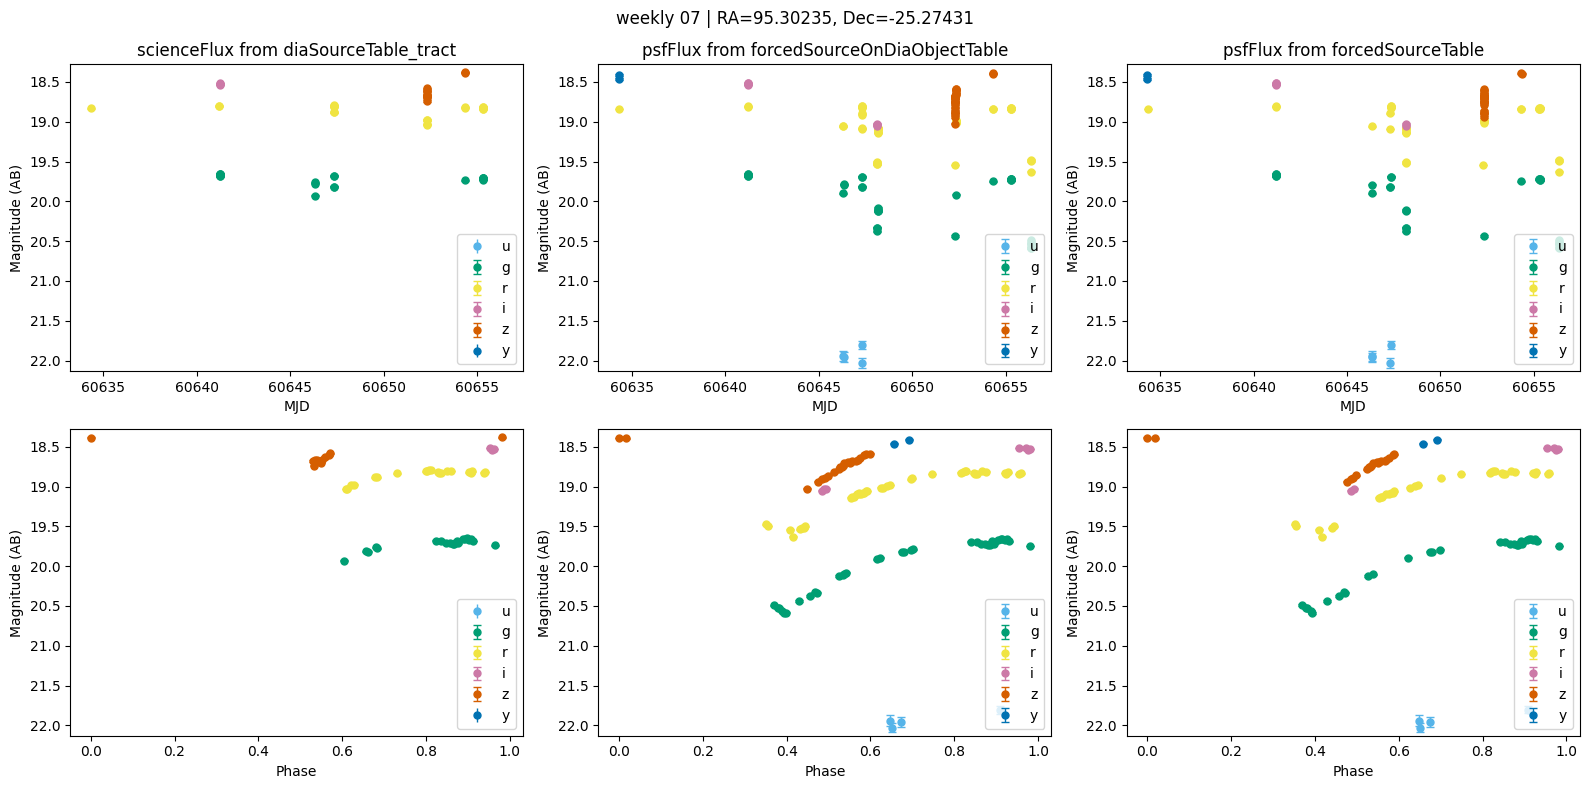

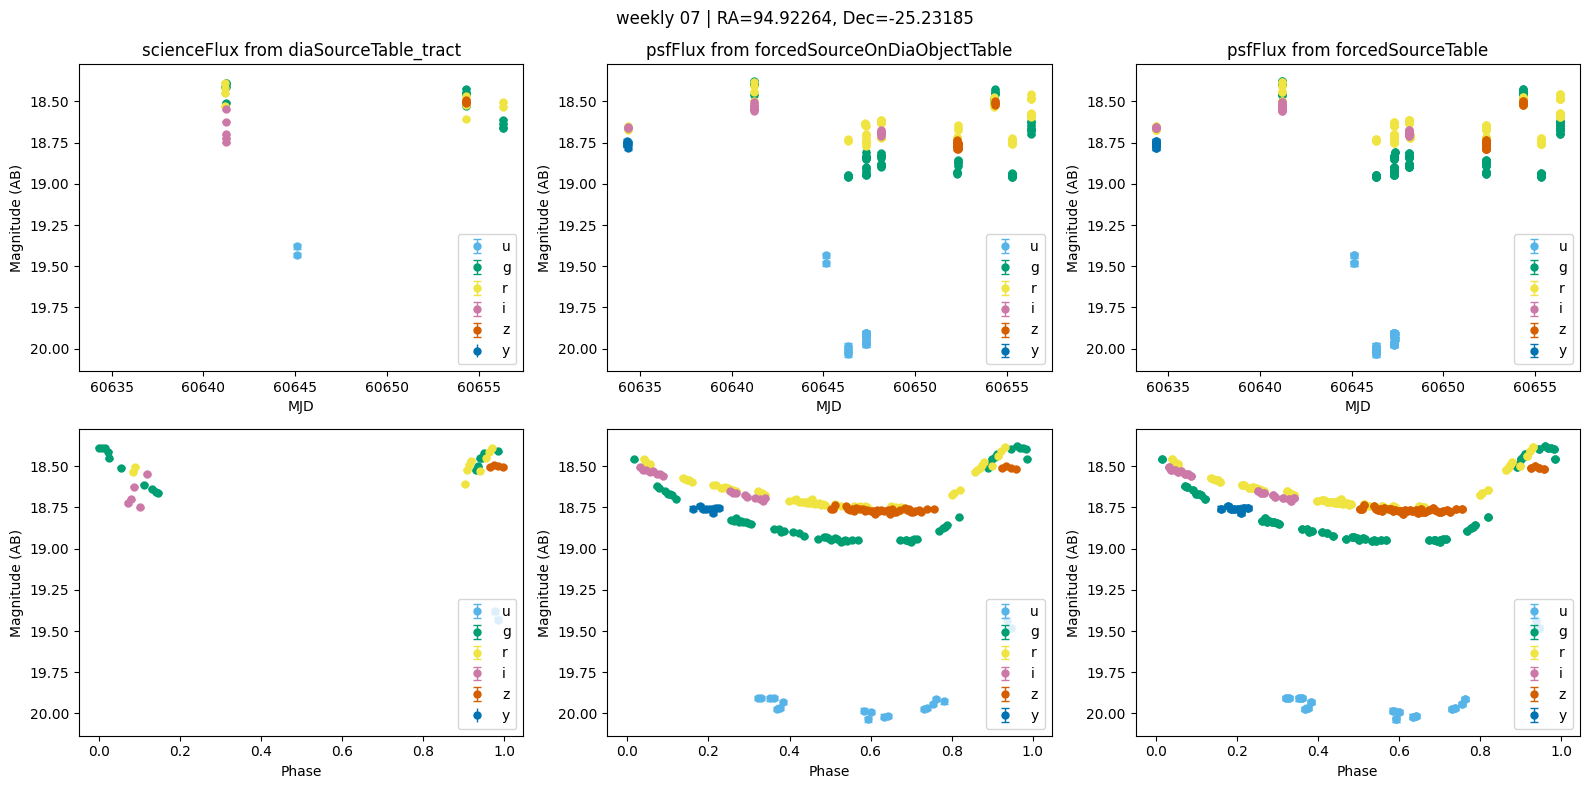

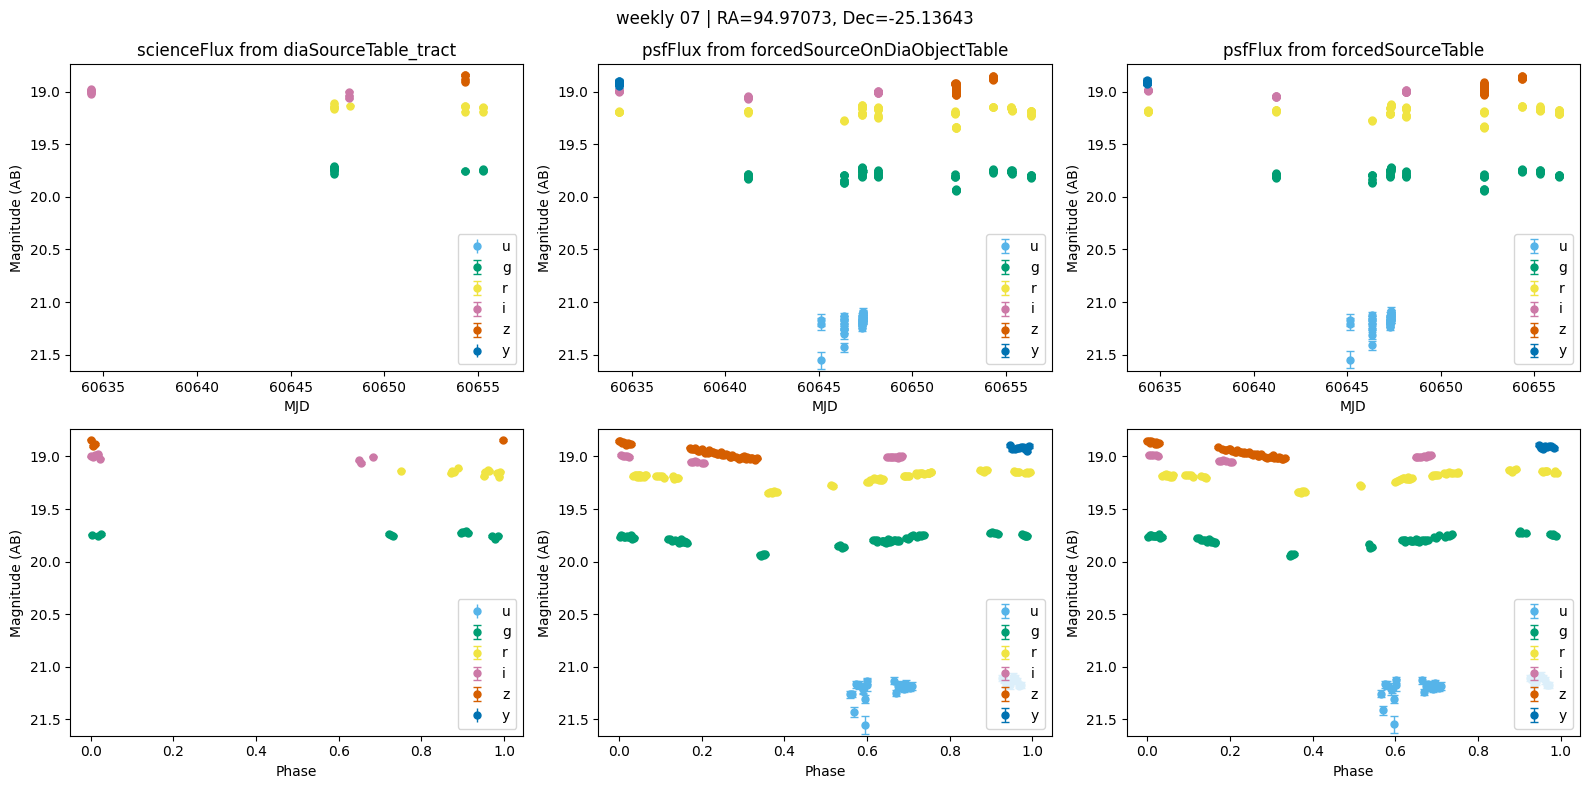

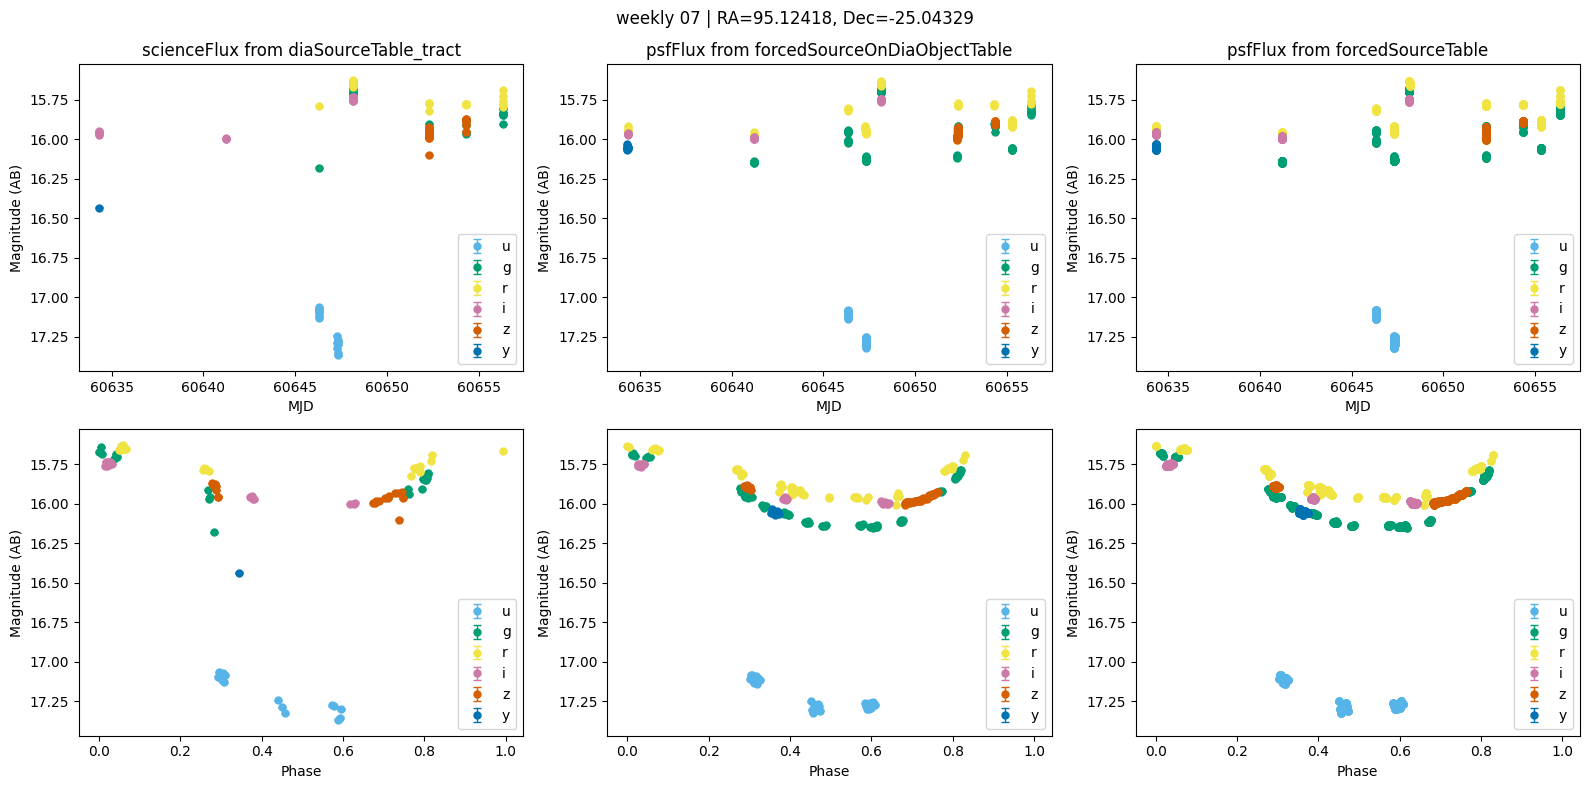

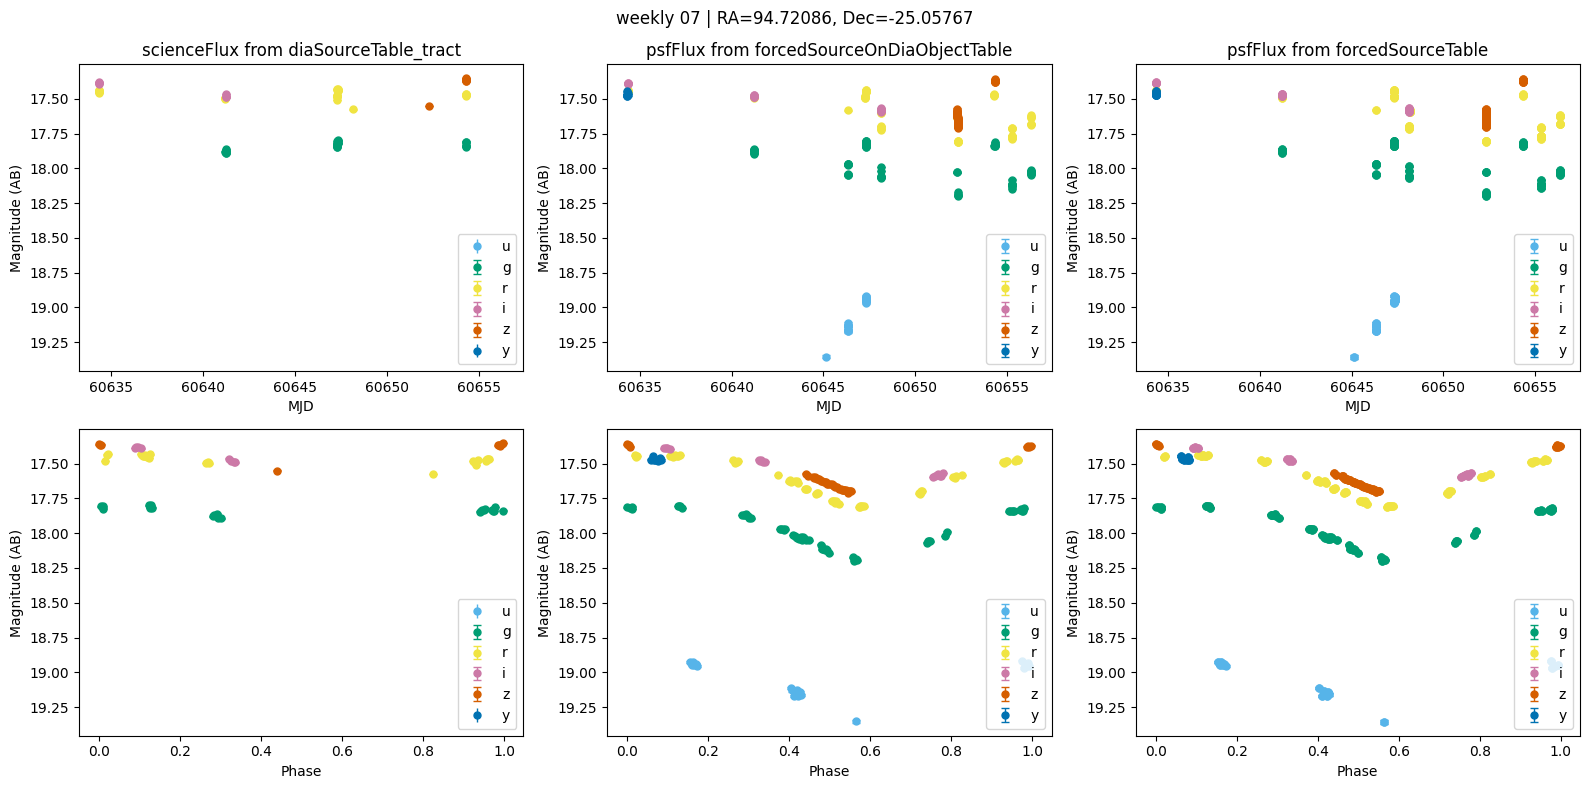

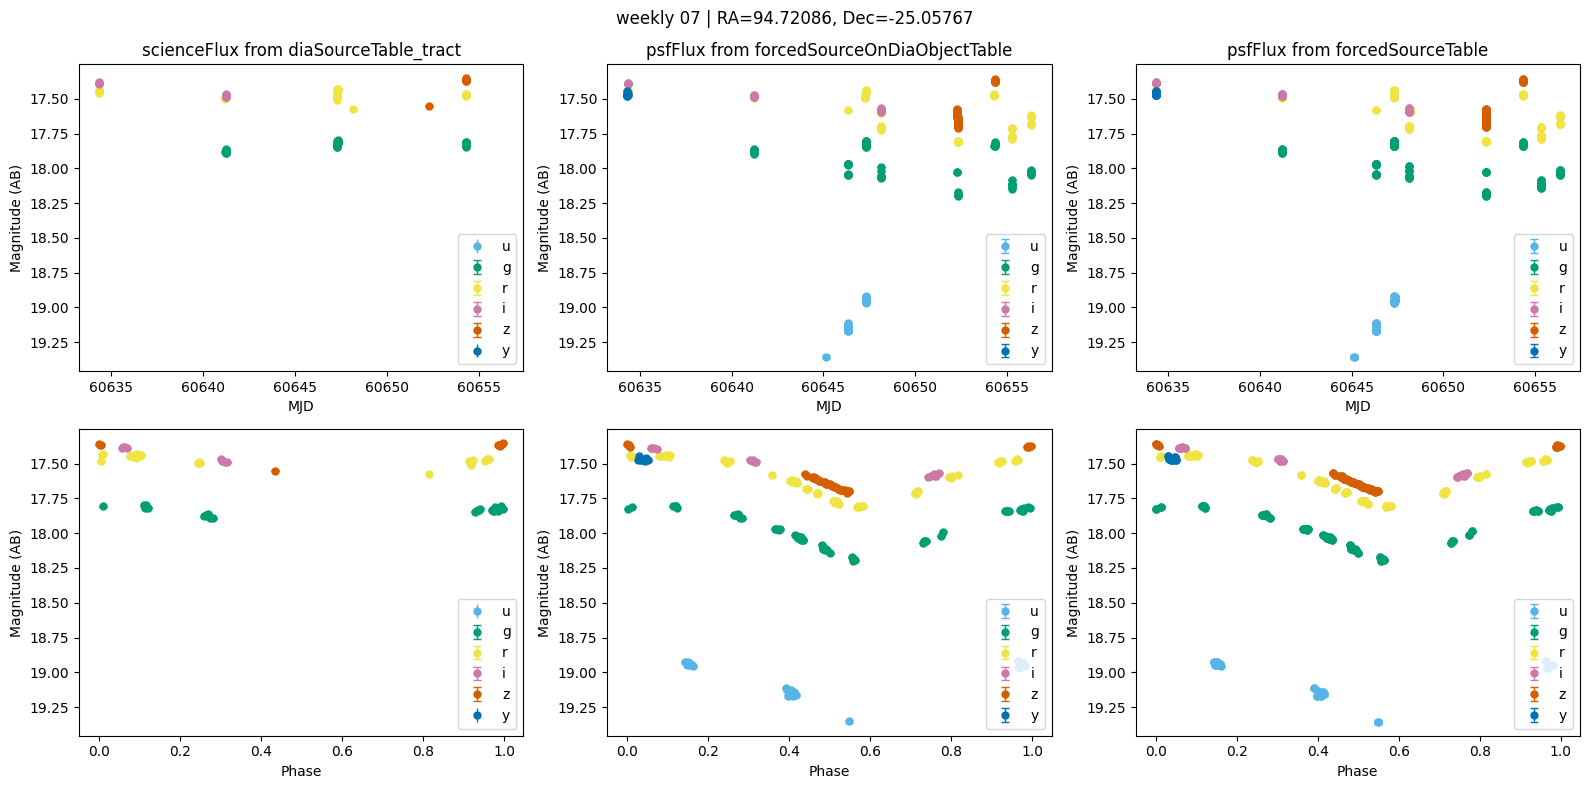

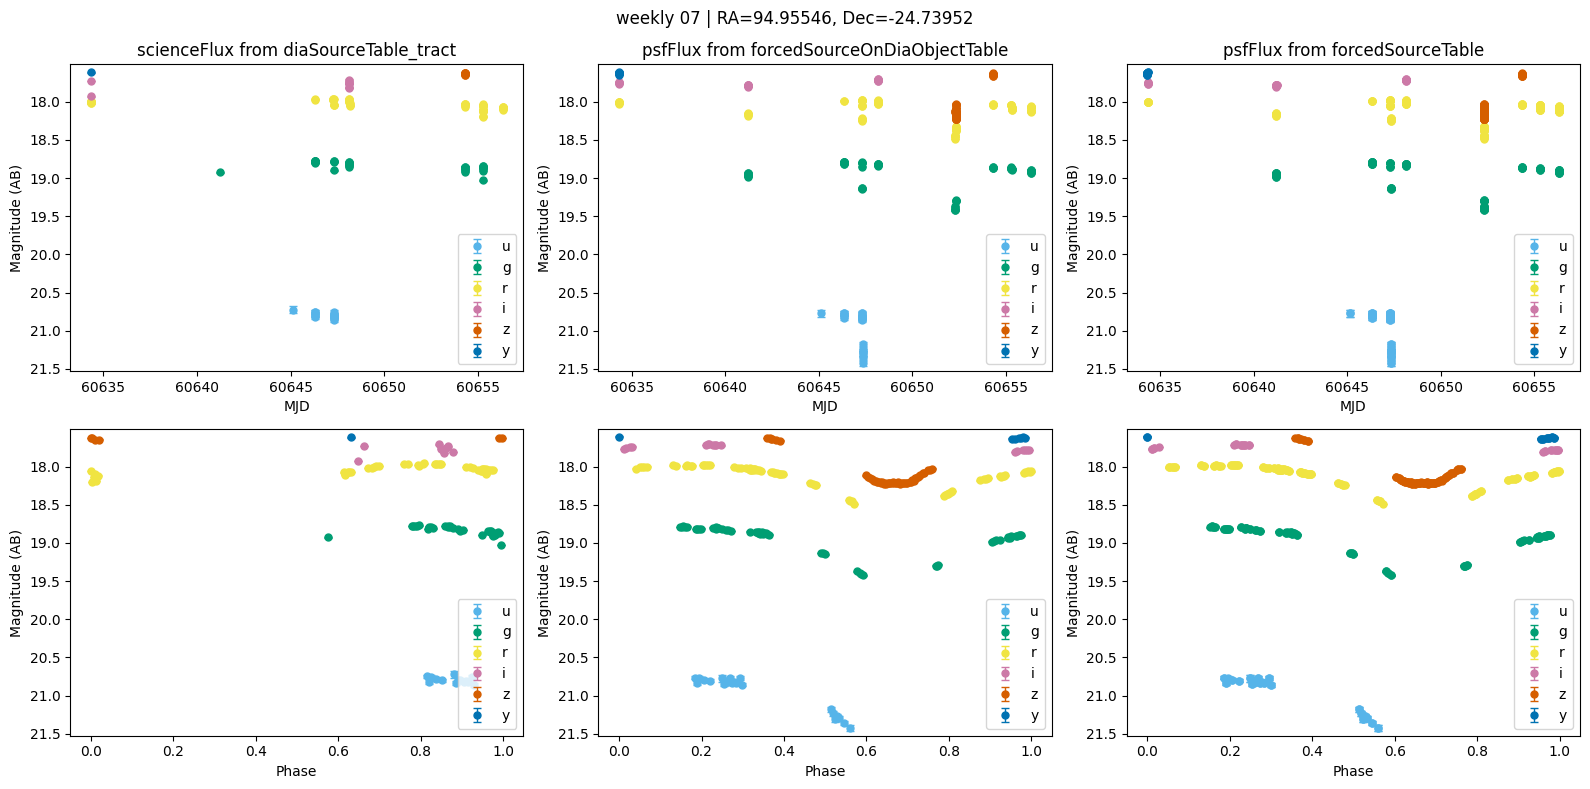

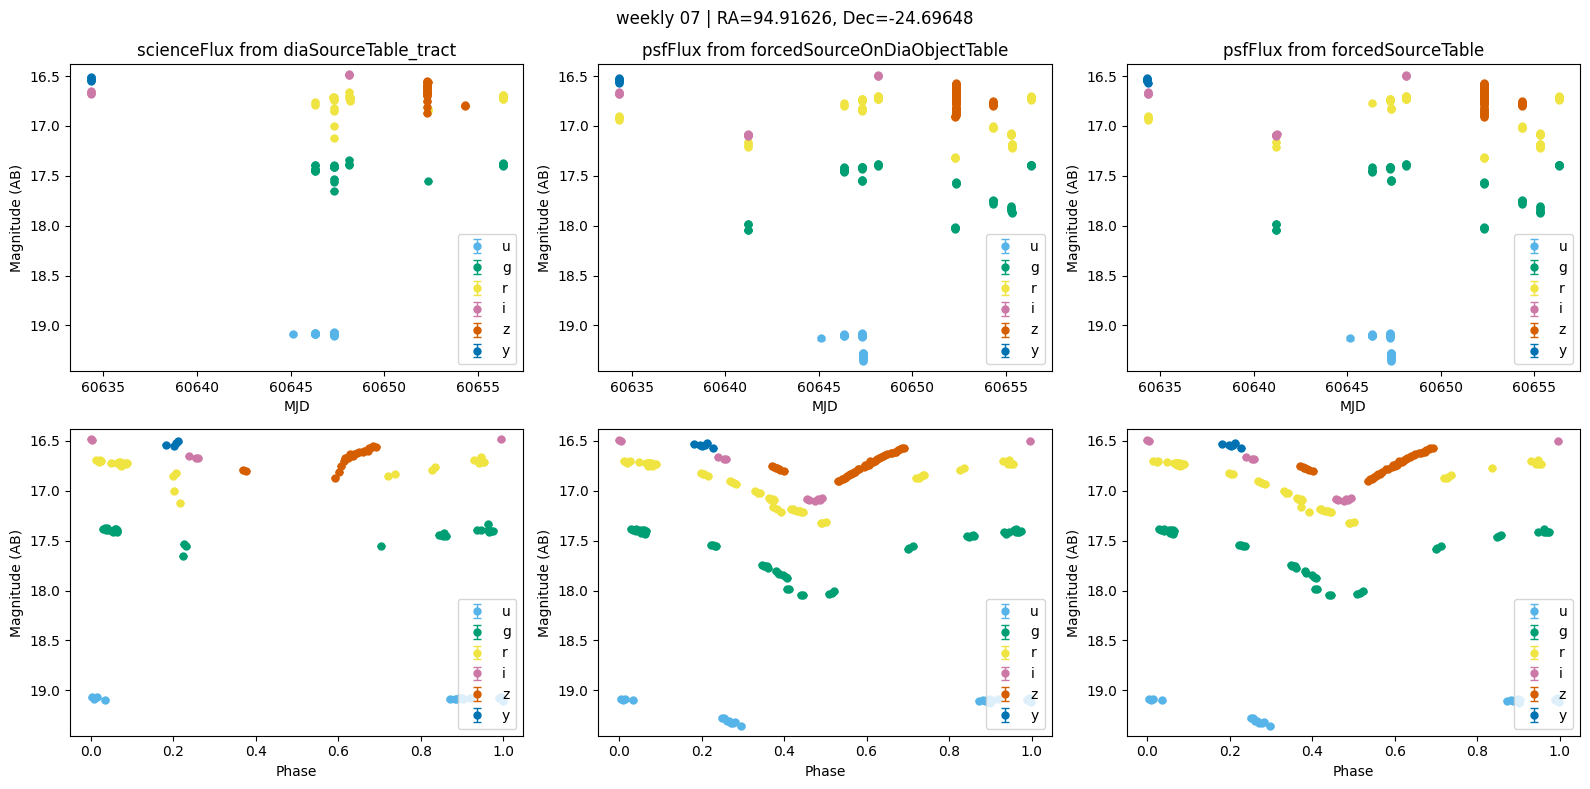

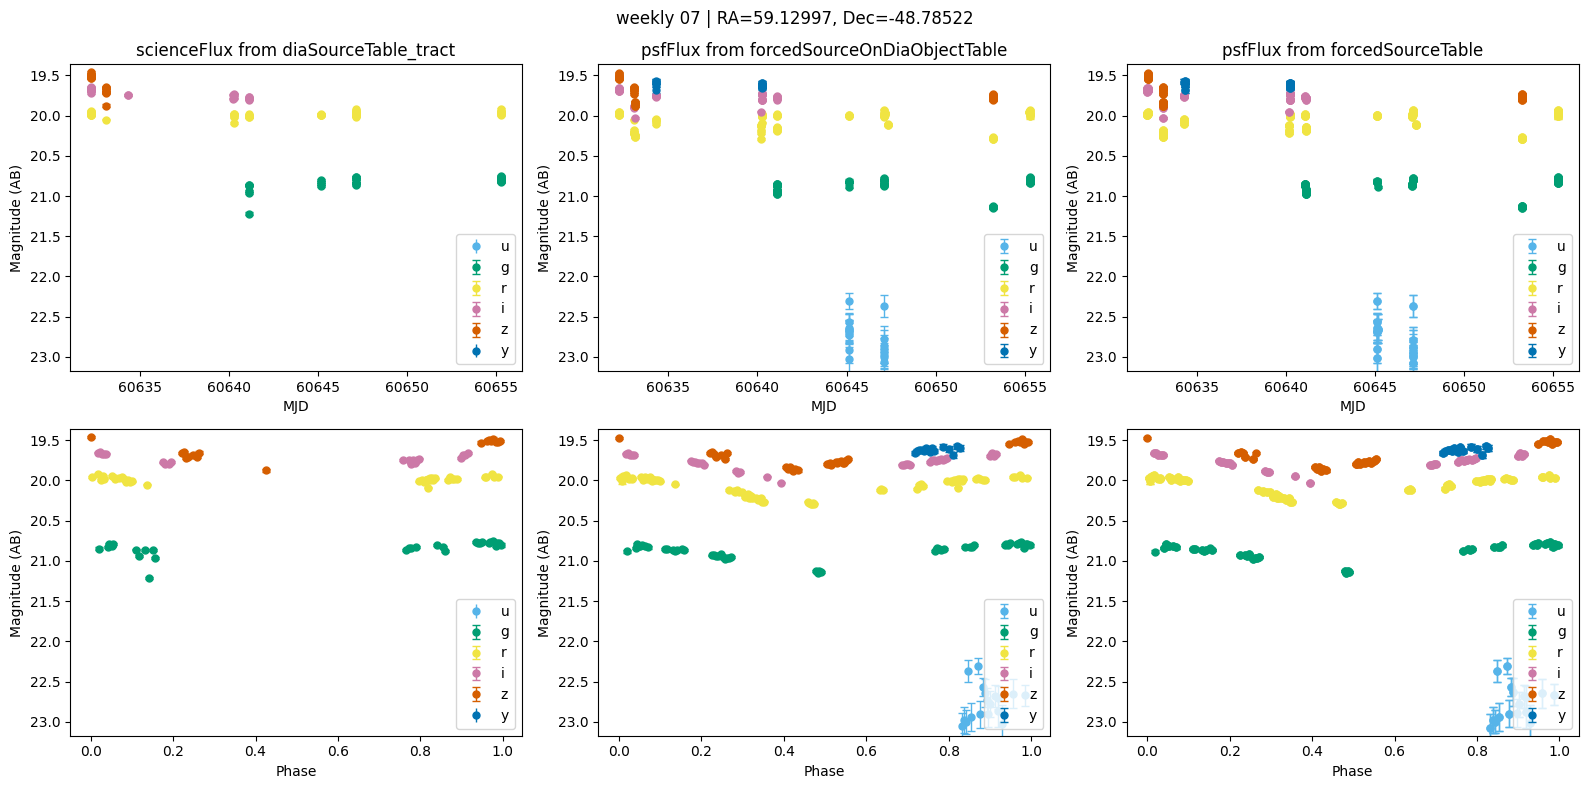

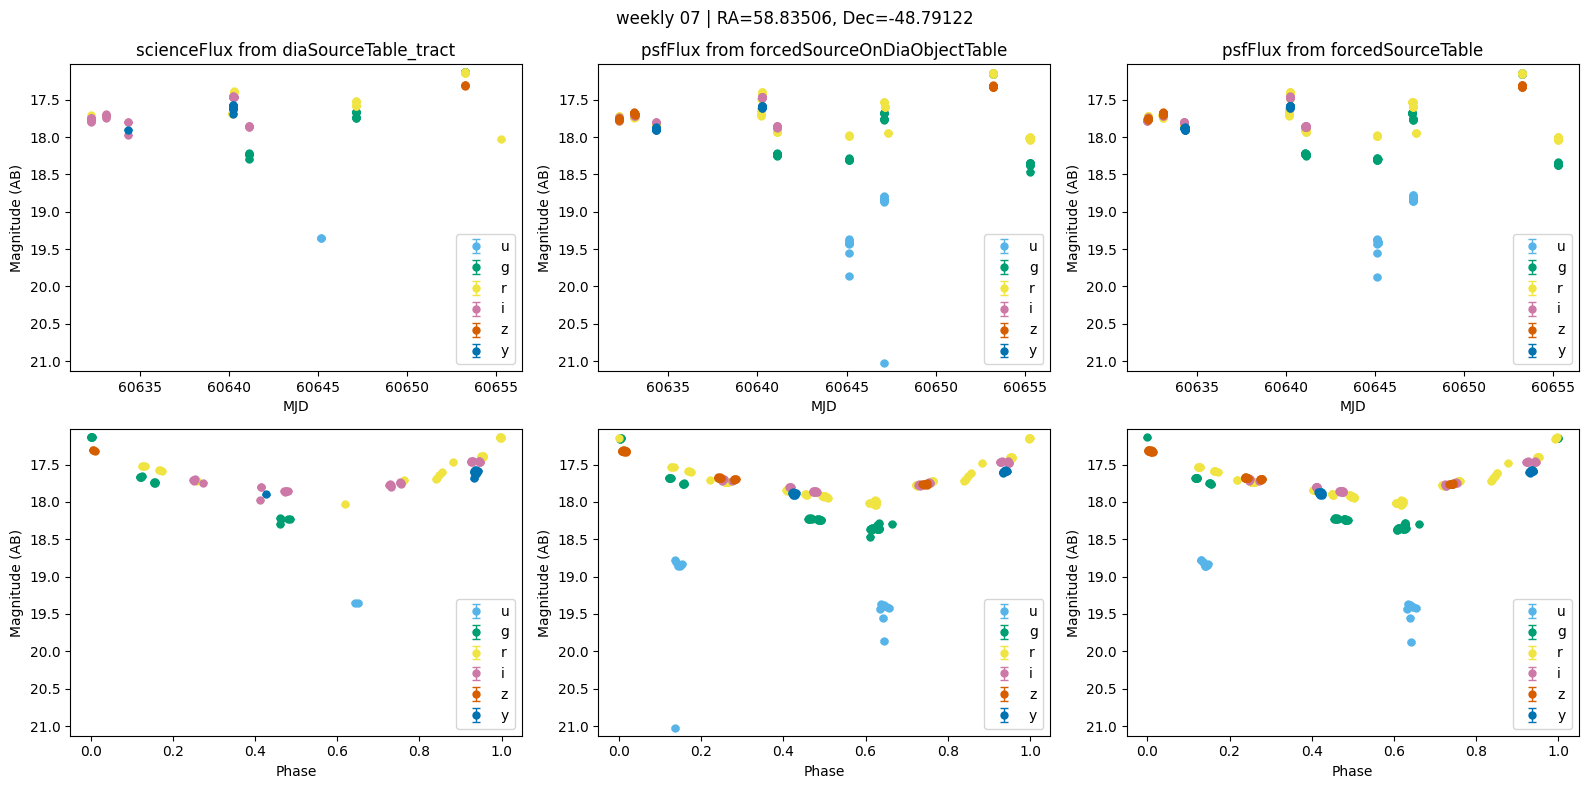

In [94]:
import matplotlib.pyplot as plt
COLORS = {
    "u": "#56b4e9",
    "g": "#009e73",
    "r": "#f0e442",
    "i": "#cc79a7",
    "z": "#d55e00",
    "y": "#0072b2",
}

# Function to plot light curves in magnitude scale
def plot(ax, lc, x_name="midpointMjdTai", x_label="MJD"):
    lc = lc.query(
        "~psfFlux_flag"
        " and ~pixelFlags_saturated"
        " and ~pixelFlags_cr"
        " and ~pixelFlags_bad"
    )

    # Use scienceFlux if available, otherwise fallback to psfFlux
    flux_col = "scienceFlux" if "scienceFlux" in lc.columns else "psfFlux"
    flux_err_col = flux_col + "Err"

    mag_values = []  # Store magnitudes for setting axis limits

    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        
        # Compute magnitudes and errors
        mag, magErr = create_mag_errors(band_lc[flux_col], band_lc[flux_err_col])

        ax.errorbar(
            band_lc[x_name], mag, magErr,
            fmt='o', label=band, color=color, alpha=1, markersize=5, capsize=3, elinewidth=1
        )

        mag_values.extend(mag.dropna().values)  # Collect magnitude values

    ax.set_xlabel(x_label)
    ax.set_ylabel("Magnitude (AB)")
    ax.invert_yaxis()  # Magnitudes are plotted with brighter objects lower
    ax.legend(loc="lower right")

    return mag_values  # Return magnitudes for axis scaling


for _, row in df.iterrows():
    fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharex="row")  # 2 rows, 3 columns

    fig.suptitle(f"weekly 07 | RA={row.ra_nice_obj:.5f}, Dec={row.dec_nice_obj:.5f}")

    all_mags = [[], []]  # To store magnitudes for each row

    for i, (lc, title) in enumerate(zip(
        [row.diaSource, row.diaForcedSource, row.forcedSource],
        ["scienceFlux from diaSourceTable_tract", "psfFlux from forcedSourceOnDiaObjectTable", "psfFlux from forcedSourceTable"]
    )):
        ax[0, i].set_title(title)

        # Compute phase
        lc = lc.assign(phase=(lc.midpointMjdTai - lc.midpointMjdTai.loc[lc.psfFlux.idxmax()]) 
                       % row.Period_nice_obj / row.Period_nice_obj)

        # First row: original light curve
        all_mags[0].extend(plot(ax[0, i], lc, x_name="midpointMjdTai", x_label="MJD"))

        # Second row: folded light curve
        all_mags[1].extend(plot(ax[1, i], lc, x_name="phase", x_label="Phase"))

    # Set uniform y-axis scaling for each row
    for row_idx in range(2):
        if all_mags[row_idx]:  # Ensure we have data
            ymin, ymax = np.nanmin(all_mags[row_idx]), np.nanmax(all_mags[row_idx])
            for i in range(3):  # Apply limits to all columns in the row
                ax[row_idx, i].set_ylim(ymax + 0.1, ymin - 0.1)  # Keep magnitude inverted

    plt.tight_layout()
    plt.show()

In [93]:
row.forcedSource

,parentObjectId,coord_ra,coord_dec,visit,detector,band,psfFlux,psfFluxErr,psfFlux_flag,psfDiffFlux,...,detect_isPrimary,detect_isTractInner,detect_isPatchInner,forcedSourceId,psfMag,psfMagErr,midpointMjdTai,Norder,Dir,Npix
0,0,58.835057,-48.791216,2024111700340,1,r,281255.471808,609.797616,False,-12422.940011,...,False,True,True,191192243007129897,17.777248,0.002354,60632.232337,8,540000,549280
1,0,58.835057,-48.791216,2024111700340,1,r,281255.483994,609.797621,False,-12422.930279,...,True,True,True,191192243007144041,17.777248,0.002354,60632.232337,8,540000,549280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,0,58.835057,-48.791216,2024121000486,1,r,34740.427722,648.726802,False,-283334.782974,...,False,True,True,192001640331477079,20.047912,0.020277,60655.280532,8,540000,549280
485,0,58.835057,-48.791216,2024121000486,1,r,34740.351875,648.726616,False,-283334.879963,...,True,True,True,192001640331483623,20.047914,0.020277,60655.280532,8,540000,549280


NameError: name 'u' is not defined

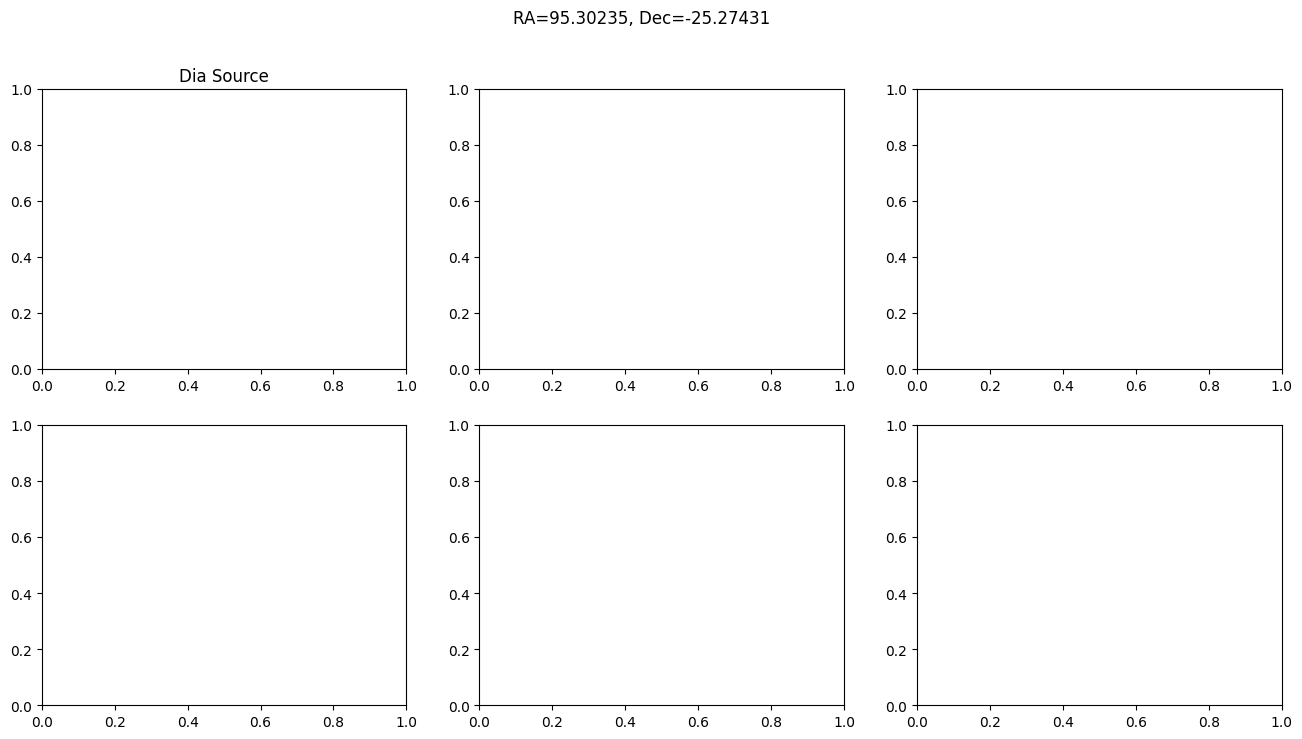

In [80]:
COLORS = {
    "u": "#56b4e9",
    "g": "#009e73",
    "r": "#f0e442",
    "i": "#cc79a7",
    "z": "#d55e00",
    "y": "#0072b2",
}


# Function to plot light curves in magnitude scale
def plot(ax, lc, x_name="midpointMjdTai", x_label="MJD"):
    lc = lc.query(
        "~psfFlux_flag"
        " and ~pixelFlags_saturated"
        " and ~pixelFlags_cr"
        " and ~pixelFlags_bad"
    )

    # Use scienceFlux if available, otherwise fallback to psfFlux
    flux_col = "scienceFlux" if "scienceFlux" in lc.columns else "psfFlux"
    flux_err_col = flux_col + "Err"

    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        
        # Compute magnitudes and errors
        mag, magErr = create_mag_errors(band_lc[flux_col], band_lc[flux_err_col])

        ax.errorbar(
            band_lc[x_name], mag, magErr,
            fmt='o', label=band, color=color, alpha=1, markersize=4, capsize=3, elinewidth=1
        )

    ax.set_xlabel(x_label)
    ax.set_ylabel("Magnitude (AB)")
    ax.invert_yaxis()  # Magnitudes are plotted with brighter objects lower
    ax.legend(loc="lower right")

for _, row in df.iterrows():
    fig, ax = plt.subplots(2, 3, figsize=(16, 8))
    for col in range(3):  # Loop over columns
        for plot_row in range(1, 2):  # Start from second row
            ax[plot_row, col].sharex(ax[0, col])  # Share x-axis with the first row of the same column
    fig.suptitle(f"RA={row.ra_nice_obj:.5f}, Dec={row.dec_nice_obj:.5f}")
    for ax_, lc, title in zip(ax, [row.diaSource, row.diaForcedSource, row.forcedSource], ["Dia Source", "Dia Forced Source", "Forced Source"]):
        ax_[0].set_title(title)
        lc = lc.assign(phase=(lc.midpointMjdTai - lc.midpointMjdTai.loc[lc.psfFlux.idxmax()]) % row.Period_nice_obj / row.Period_nice_obj)
        plot(ax_[0], lc, x_name="midpointMjdTai", x_label="MJD")
        plot(ax_[1], lc, x_name="phase", x_label="phase")
    plt.tight_layout()
    plt.show()